# Introduction

_Describe the problem the software solves and why it's important to solve that problem._

* Our software package computes gradients by leveraging the technique of automatic differentiation. Before we can understand automatic differentiation, we must first describe and motivate the importance of differentiation itself. Finding the derivative of a function measures the sensitivity to change of a function value with respect to a change in its input argument. Derivatives are not only essential in calculus applications like numerically solving differential equations and optimizing and solving linear systems, but are useful in many real world, scientific settings. For example, differentiation is essential in analyzing the profit and loss of a company's business or finding the minimum amount of material to construct a building.   


* To perform differentiation, two different approaches are solving the task symbolically or numerically computing the derivatives. Symbolic differentation yields accurate answers, however depending on the complexity of the function, it could be expensive to evaluate and result in inefficient code. On the other hand, numerically computing derivatives is less expensive, however it suffers from potential issues with stability and a loss of accuracy.   


* Automatic differentiation overcomes the shortcomings of both the symbolic and numerical approach. Automatic differentiation is less costly than symbolic differentiation, but evaluates derivatives at machine precision. The technique leveages both forward mode and reverse mode and evaluates each step with the results of previous computations or values. As a result of this, autuomatic differentiation avoids finding an analytical expresssion for the derivative itself and is thus iteratively evaluating a gradient based on input values. Thus, based on these key advantages, our library implements and performs forward mode automatic differentiation to efficiently and accurately compute derivatives.

# Background

_Describe (briefly) the mathematical background and concepts as you see fit._


#### 1: Chain Rule 

At the heart of automatic differentiation is the Chain Rule that enables us to decompose a complex derivative into a set of derivatives involving elementary functions of which we know explicit forms. 

We will first introduce the case of 1-D input and generalize it to multidimensional inputs.

1-D input: Suppose we have a function $ h(u(t)) $ and we want to compute the derivative of $ h $ with respect to $ t $. This derivative is given by

$$
\begin{align}
\frac{dh}{dt} = \frac{\partial h}{\partial u} \frac{du}{dt}\\
\end{align}
$$

Before introducing vector inputs, let's first take a look at the gradient operator $ \nabla $

That is, for  $ y\colon \mathbb {R} ^{n} \to \mathbb {R} $, its gradient $ \nabla y \colon \mathbb {R} ^{n} \to \mathbb {R} ^{n}$ is defined at the point $ x = (x_1, ..., x_n) $ in n-dimensional space as the vector

$$
\begin{align}
\nabla y(x) =
\begin{bmatrix}
{\frac {\partial y}{\partial x_{1}}}(x)
\\
\vdots 
\\
{\frac {\partial y}{\partial x_{n}}}(x)
\end{bmatrix}
\end{align}
$$

Multidimensional (or Vector) inputs: Suppose we have a function $ h(y_1(x), ..., y_n(x)) $ and we want to compute the derivative of $ h $ with respect to $ x $. This derivative is given by:

$$
\begin{align}
\nabla h_x = \sum_{i=1}^n \frac{\partial h}{\partial y_i} \nabla y_i(x)\\
\end{align}
$$

#### 2: Evaluation (Forward) Trace
Definition: Suppose x = $ \begin{bmatrix} {x_1} \\ \vdots \\ {x_m} \end{bmatrix} $, we defined $ v_{k - m} = x_k $ for $ k = 1, 2, ..., m $ in the evaluation trace.

Motivation: The evaluation trace introduces intermediate results $ v_{k-m} $ of elementary unary or binary operations.

Consider the function $ f(x):\mathbb{R}^2 \to \mathbb{R} $

$ f(x) = x_1 x_2 + sin(x_1 x_2) $

We want to evaluate the gradient $ \nabla f $ at the point $ x = \begin{bmatrix} 7 \\ 4 \end{bmatrix} $. Computing gradient by hand gives: 

$ \nabla f = \begin{bmatrix} \frac {\partial f} {\partial x_1} \\ \frac {\partial f} {\partial x_2} \end{bmatrix}  = \begin{bmatrix} x_2 + x_2 sin(x_1 x_2) \\ x_1 + x_1 sin(x_1 x_2) \end{bmatrix} = \begin{bmatrix} 4 + 4sin(28) \\ 7 + 7sin(28) \end{bmatrix}$

| Forward primal trace | Forward tangent trace | Pass with p = $[0, 1]^T$ | Pass with p = $[1, 0]^T$ |
| --- | --- | --- | --- |
| $v_{-1} = x_1$ | $ p_1 $ | 1 | 0 |
| $v_{0} = x_2$ | $ p_2 $ | 0 | 1 |
| $v_{1} = v_{-1} v_0$ | $ v_0 D_p v_{-1} + v_{-1} D_p v_0 $ | 4 | 7 |
| $v_{2} = sin(v_{-1} v_0)$ | $ cos(v_{-1} v_0) D_p v_{1} $ | 4 cos(28) | 7 cos(28) |
| $v_{3} = v_{1} + v_{2}$ | $ D_p v_1 + D_p v_2 $ | 4 + 4 cos(28) | 7 + 7 cos(28) |

$D_p v_{-1} = \nabla v_{-1}^T p = (\frac {\partial v_{-1}} {\partial x_1} \nabla x_{1})^T p = (\nabla x_{1})^T p = p_1$

$D_p v_{0} = \nabla v_{0}^T p = (\frac {\partial v_{0}} {\partial x_2} \nabla x_{2})^T p = (\nabla x_{2})^T p = p_2$

$D_p v_{1} = \nabla v_{1}^T p = (\frac {\partial v_{1}} {\partial v_{-1}} \nabla v_{-1} + \frac {\partial v_{1}}{\partial v_{0}} \nabla v_{0})^T p = (v_0 \nabla v_{-1} + v_{-1} \nabla v_0)^T p = v_0 D_p v_{-1} + v_{-1} D_p v_0$

$D_p v_{2} = \nabla v_{2}^T p = (\frac {\partial v_{2}} {\partial v_{-1}} \nabla v_{-1} + \frac {\partial v_{2}}{\partial v_{0}} \nabla v_{0})^T p = (v_0 cos(v_{-1} v_0) \nabla v_{-1} + v_{-1} cos(v_{-1} v_0) \nabla v_0)^T p = cos(v_{-1} v_0) (v_0 D_p v_{-1} + v_{-1} D_p v_0) = cos(v_{-1} v_0) D_p v_{1}$

$D_p v_{3} = \nabla v_{3}^T p = (\frac {\partial v_{3}} {\partial v_{1}} \nabla v_{1} + \frac {\partial v_{3}}{\partial v_{2}} \nabla v_{2})^T p = D_p v_1 + D_p v_2$

#### 3: Computation (Forward) Graph

We have associated each $ v_{k-m} $ to a node in a graph for a visualization of the partial ordering.

From above example, its computational graph is given by the following: 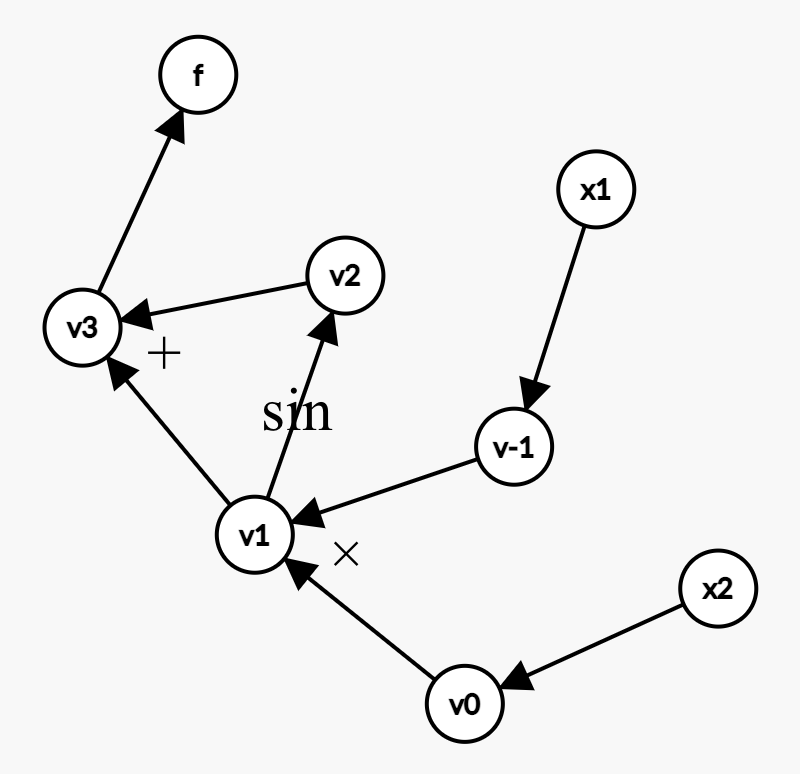


#### 4: Computing the derivative

Let's return to the gradient $ \nabla $

Definition of gradient operator: we project the gradient from before in the direction of $ p $

$$ D_p v_j = (\nabla v_j)^T p = (\sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} \nabla v_i)^T p = \sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} (\nabla v_i)^T p = \sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} D_p v_i$$ 

Higher dimension: We recursively apply the same technic introduced above to each entry of the vector valued function f

Two take away messages: 

1) We can compute the derivative of $ v_j $ with knowledge of $ v_i $ and $ D_p v_i $ for $ i < j $.

2) Once a child node is evaluated, its parent node(s) are no longer needed. There is no need to store the full graph of and pairs.

#### 5: Dual Number

Definition: we define a dual number $ z_j = v_j + D_p v_j \epsilon $ such that $ \epsilon^2 = 0 $ where $ v_j $ corresponds to primal trace and $ D_p v_j $ corresponds to tangent trace. 

$ f(z_j) = f(v_j + D_p v_j \epsilon) = f(v_j) + f'(v_j) D_p v_j \epsilon $ using a Taylor series expansion

All higher term vanish because of the definition $ \epsilon^2 = 0 $

Advantage: Operations on Dual Number pertain the form of Taylor expansion.

Consider the following example
$$
\begin{align}
z_1 &= a_1 + b_1 \epsilon \\ 
z_2 &= a_2 + b_2 \epsilon \\
z_1 + z_2 &= (a_1 + a_2) + (b_1 + b_2) \epsilon \\
z_1 z_2 &= a_1 a_2 + (a_1 b_2 + a_2 b_1) \epsilon \\
\end{align}
$$

We subsititute $ a_1 = u, b_1 = u' $ and $ a_2 = v $ and $ b_2 = v' $,
$$
\begin{align}
z_1 + z_2 &= (u + v) + (u' + v') \epsilon \\
z_1 z_2 &= u v + (u v' + u' v) \epsilon \\
\end{align}
$$

# How to Use ad-AHJZ

_How do you envision that a user will interact with your package? What should they import? How can they instantiate AD objects?_

#### 1. __Installing the package:__
   * 1a. User starts their virtual environment and installs our package with the following line
    
    <code>python3 -m pip install AHJZ_autodiff </code>
      
   * 1b. User installs dependencies from requirements.txt with the following command: 

    <code>python3 -m pip install requirements.txt </code>


#### 2. __Importing the package:__

   * 2a. User imports package into their desired python environment with the following line
    
    ```python
    from ad-AHJZ import functions, forward-mode, extension-module as ad
    ```
    
   * 2b. User imports numpy into their desired python environment with the following line:  
    
    ```python
    import numpy as np
    ```
    
    
#### 3. __Calling/Using package modules:__
   * 3a. User makes use of the prefix "ad" and can call the different methods listed in the following files to perform automatic differentiation on both scalar and vector quantities:  

   * 3b. Example function calls for scalar case

    ```python
    # define desired evaluation value (scalar)
    temp = np.array([0.5]) 
    # define a function to fund the derivative of
    f_x = math.sin(temp) + 2 * temp
    # call forward mode method
    fm = ad.forwardmode(evaluate = temp, function = f_x)
    # store function value, first derivative, last operations done to obtain the function value, last operation done to obtain the derivative value
    x, x_der, x_expression, x_der_expression = fm
    # extract and store the function value and first derivative
    val = x
    df_dx = x_der

    ```
   * 3c. Example function calls for vector case
    ```python    
    # define desired evaluation value (scalar)
    temp = np.array([0.5, 0.5, 1, 1, 2]) 
    # define a function to fund the derivative of
    f_x = math.cos(temp) + 10 * temp
    # call forward mode method
    fm = ad.forwardmode(evaluate = temp, function = f_x)
    # store function value, first derivative, last operations done to obtain the function value, last operation done  to obtain the derivative value
    x, x_der, x_expression, x_der_expression = fm
    # extract and store the function value and first derivative
    val = x
    df_dx = x_der
    ```

# Software Organization

_Discuss how you plan on organizing your software package._


#### 1. __Directory Structure:__
   * 1a. We include our project directory structure in the image below. Our package is called AHJZ_autodiff, where our code for automatic differentiation lies within "AHJZ_autodiff", our milestone documentation lies within "docs", all unit testing files are located in "testing", and the root of the directory holds our readme, license, and requirements.txt file.
    
   * 1b. Directory structure layout: 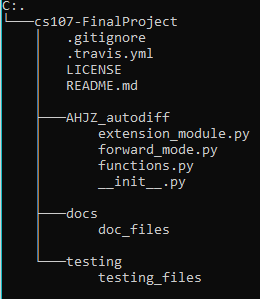

#### 2. __Modules:__
   * 2a. _functions.py_: This file contains sixteen methods to compute the function values and derivitives of the elementary operations outlined below. These functions form the partial computational pieces required to perform automatic differentiation. The sixteen elementary functions are the following: '+', '-', '*' '/', 'sqrt(x)', 'power(x,n)', 'exp(x)', 'log(x, b)', 'ln(x)', 'sin(x)', 'cos(x)', 'tan(x)', 'cot(x)', 'csc(x)', 'sec(x)'.
    
   * 2b. _forward_mode.py_: This file computes the gradient using the forward mode of automatic differentiation. A user is required to input the function they are interested in computing the derivative of and the point at which the derivative is to be evaluated at.
    
   * 2c. _fast_forward_mode.py_ (extension module): This file will contain our extension to the basic automatic differentiation functionality. In this module we compute the gradient using an efficient version of forward mode of automatic differentation by using an efficient graph data structure and optimized tree traversal. A user is required to input the function they are interested in computing the derivative of and the point at which the derivative is to be evaluated at. 


#### 3. __Test Suite Location:__
   * 3a. The test suite will live in the "testing" directory which is a subdirectory found off the root directory (see 1. Directory Structure). The "testing" directory will contain all unit tests for our different modules. 
    
   * 3b. To ensure our testing procedure has complete code coverage, we will leverage CodeCov. CodeCov will enable us to quickly understand which lines are being executed in our test cases. Moreover, we will make use of TravisCI in order to see which of our unit tests are passing/failing. 
    
    
#### 4. __Package Distribution:__
   * 4a. The package will be distributed via PyPI. To deploy our package on PyPI and make it available for others to use, we would also need to add setup.py and a setup.cfg files. After creating an account, a user would execute the setup.py file and can distribute the project. 


#### 5. __Packaging the Software:__
   * 5a. The software will be packaged using...?


#### 6. __Other Considerations: Package Dependencies__
   * 6a. The only library dependency our package will rely on is numpy. We design our software this way to ensure that we are not creating multiple external dependencies.


# Implementation

_Discuss how you plan on implementing the forward mode of automatic differentiation._

#### 1.  __Core Data Structure:__
   * 1a. Our primary core data structure is going to be a dictionary to store each node in the computational graph that uses the tangent trace and primal trace to compute the partial differentiation and function value for a specific variable. More specifically, the keys would be the node of the computational graph (state name) and the values are going to be a tuple that holds the associated operation at the specific state (function value and derivative).  
      
      
#### 2.  __Classes:__
    
   * 2a. _Dual Numbers_: Class which represents a dual number    
    
   * 2b. _Forward Mode_: Class which represents the computational graph and performs forward mode differentiation  
     
   * 2c. _Fast Forward Mode_ (extension module): Class which represents an optimized compututional graph and perfroms a faster version of forward mode differentiation by efficiently storing the graph and doing clever graph traversal.
    
    
#### 3.  __Method and Name Attributes:__
   * 3a. _Dual Numbers_:
        * Method to initialize the real value and dual number value for the input of the function          
        * Methods to overload the elementary operations for a varaible that is dual number
            * For example, we would use the below method to overload the "add" operation: 
            ```python  
               def __add__(self, other):
                        if isinstance(other, DualNumber):
                            return DualNumber(self.real + other.real, self.dual + other.dual)
            ```
   * 3b. _Forward Mode_:
        * Method to initialize the computational graph dictionary, its initial _x_ value, and an empty dictionary of the primal trace and tangent trace to perform forward mode automatic differentiation
        * Method to iterate through the input function and append to the primal and tangent trace dictionary
        * Method to get the node value and partial derivative at the current step of forward mode
        * Method to obtain the primal trace to arrive at the next node's value and partial derivative
        * Method to obtain the tangent trace to arrive at the next node's value and partial derivative
        * Method to run the entire forward mode process and obtain the final function value and derivative from the computational graph.  
          
   * 3c. _Fast Forward Mode_:
        * Method to initialize the optimized computational graph data structure, its initial _x_ value, and an empty optimized structure of the primal and tangent trace to perform forward mode automatic differentiation
        * Method to iterate through the input function and append to the primal and tangent trace data structure
        * Method to get the node value and partial derivative at the current step of forward mode
        * Method to obtain the primal trace to arrive at the next node's value and partial derivative
        * Method to obtain the tangent trace to arrive at the next node's value and partial derivative
        * Method to efficiently run the entire forward mode process and obtain the final function value and derivative from the optimized computational graph.
    
   
#### 4. __External Dependencies:__
   * 4a. The only external library we will rely on is numpy, which we will use to perform computations and evaluate small expressions with. With this being our only external dependency, our software increases its reliability and can be viewed as a near stand alone software package. 
    
    
#### 5.  __Dealing With Elementary Functions__
   * 5a. For all elementary functions like _sin_, _sqrt_, _log_, and _exp_ (and all the others mentioned in _Modules_) we will define separate methods for them in functions.py. This module will generalize each of the functions in order to handle both scalar and vector input. Each method will take in as input a vector or scalar value stored at the previous node in the computational graph and output the derivative value and function value for the elementary function. We can then store the methods' outputs as a tuple in the computational graph dictionary. 
   
   * 5b. For example, we would use the below functions to implement _sin_ and _sqrt_, both of which work with scalar or vector input _x_ values: 
```python  
    def sin(x): 
        x_val = np.sin(x)
        x_der = np.cos(x)
        return (x_val, x_der)
```
```python  
    def sqrt(x): 
        x_val = np.sqrt(x)
        x_der = 0.5 * np.power(x, -0.5)
        return (x_val, x_der)
```


# Licensing

_Briefly motivate your license choice_

Our AHJZ_autodiff package is licensed under the GNU General Public License v3.0. This free software license allows users to do just about anything they want with our project, except distribute closed source versions. This means that any improved versions of our package that individuals seek to release must also be free software. We find it essential to allow users to help each other share their bug fixes and improvements with other users. Our hope is that users of this package continually find ways to improve it and share these improvements within the broader scientific community that uses automatic differentation.